# 0. Import thư viện

In [33]:
!pip install pandera

In [34]:
import pandas as pd
from pandas.plotting import scatter_matrix

import numpy as np

%matplotlib inline
from matplotlib import pyplot as plt

import pandera as pa
from pandera.errors import SchemaError

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

# 1. Phân tích Khám phá Dữ liệu

In [35]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
!ln -s "/content/drive/MyDrive/Datasets/personality_datasert.csv" "/content/personality.csv"

ln: failed to create symbolic link '/content/personality.csv': File exists


In [37]:
df = pd.read_csv("personality.csv")
df.head()

,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,4.0,No,4.0,6.0,No,13.0,5.0,Extrovert
1,9.0,Yes,0.0,0.0,Yes,0.0,3.0,Introvert
2,9.0,Yes,1.0,2.0,Yes,5.0,2.0,Introvert
3,0.0,No,6.0,7.0,No,14.0,8.0,Extrovert
4,3.0,No,9.0,4.0,No,8.0,5.0,Extrovert


In [38]:
df.describe()

,Time_spent_Alone,Social_event_attendance,Going_outside,Friends_circle_size,Post_frequency
count,2900.000000,2900.000000,2900.000000,2900.000000,2900.000000
mean,4.505816,3.963354,3.000000,6.268863,3.564727
std,3.441180,2.872608,2.221597,4.232340,2.893587
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,2.000000,1.000000,3.000000,1.000000
50%,4.000000,3.963354,3.000000,5.000000,3.000000
75%,7.000000,6.000000,5.000000,10.000000,6.000000
max,11.000000,10.000000,7.000000,15.000000,10.000000


In [39]:
df["Personality"].value_counts()

,count
Personality,
Extrovert,1491
Introvert,1409


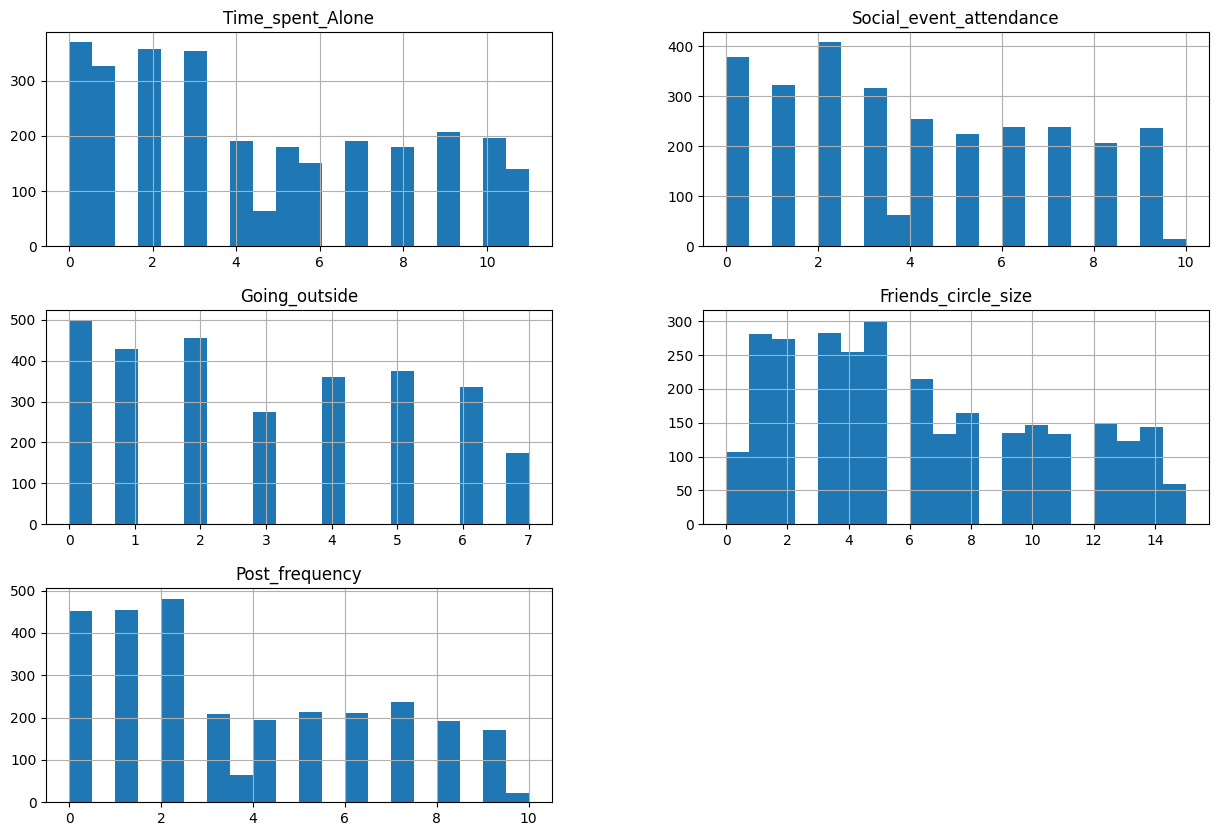

In [40]:
df.hist(bins=20, figsize=(15, 10))
plt.show()

array([[<Axes: xlabel='Time_spent_Alone', ylabel='Time_spent_Alone'>,
        <Axes: xlabel='Social_event_attendance', ylabel='Time_spent_Alone'>,
        <Axes: xlabel='Going_outside', ylabel='Time_spent_Alone'>,
        <Axes: xlabel='Friends_circle_size', ylabel='Time_spent_Alone'>,
        <Axes: xlabel='Post_frequency', ylabel='Time_spent_Alone'>],
       [<Axes: xlabel='Time_spent_Alone', ylabel='Social_event_attendance'>,
        <Axes: xlabel='Social_event_attendance', ylabel='Social_event_attendance'>,
        <Axes: xlabel='Going_outside', ylabel='Social_event_attendance'>,
        <Axes: xlabel='Friends_circle_size', ylabel='Social_event_attendance'>,
        <Axes: xlabel='Post_frequency', ylabel='Social_event_attendance'>],
       [<Axes: xlabel='Time_spent_Alone', ylabel='Going_outside'>,
        <Axes: xlabel='Social_event_attendance', ylabel='Going_outside'>,
        <Axes: xlabel='Going_outside', ylabel='Going_outside'>,
        <Axes: xlabel='Friends_circle_size', yla

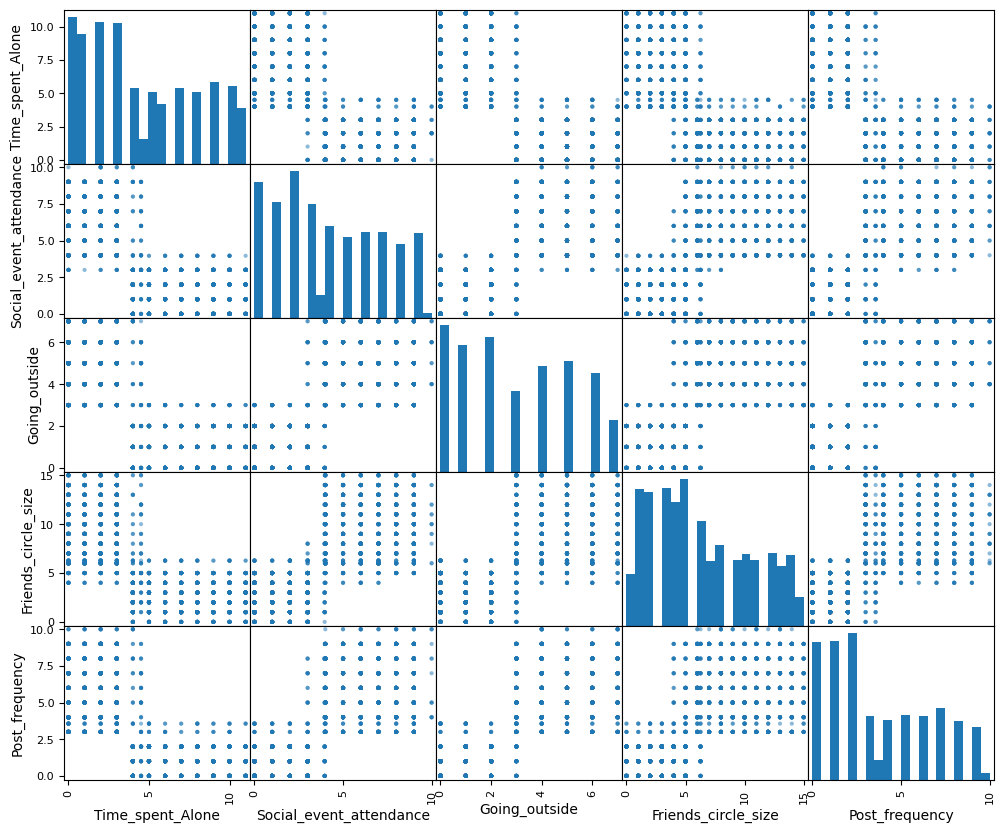

In [41]:
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import LabelEncoder

df_encoded = df.copy()
df_encoded["Personality"] = LabelEncoder().fit_transform(df["Personality"])

selected_cols = df_encoded.columns[:-1]
scatter_matrix(df_encoded[selected_cols], figsize=(12, 10), hist_kwds={'bins': 20})

# 2. Kiểm định dữ liệu

In [42]:
personality_schema = pa.DataFrameSchema({
    "Time_spent_Alone": pa.Column(float, pa.Check.in_range(0, 24)),
    "Social_event_attendance": pa.Column(float, pa.Check.in_range(0, 10)),
    "Going_outside": pa.Column(float, pa.Check.in_range(0, 7)),
    "Friends_circle_size": pa.Column(float, pa.Check.in_range(0, 15)),
    "Post_frequency": pa.Column(float, pa.Check.in_range(0, 10)),
    "Personality": pa.Column(str, pa.Check.isin(["Introvert", "Extrovert"]))
})

In [43]:
try:
    validated_df = personality_schema.validate(df)
    print("✅ Dữ liệu đã vượt qua kiểm định thành công!")

except SchemaError as e:
    print("❌ Dữ liệu không hợp lệ!")
    print("Chi tiết lỗi:")
    print(e)

✅ Dữ liệu đã vượt qua kiểm định thành công!


In [44]:
df_invalid = df.copy()

df_invalid.loc[0, "Time_spent_Alone"] = 30
df_invalid.loc[1, "Post_frequency"] = -1
df_invalid.loc[2, "Personality"] = "Shy"
df_invalid.loc[3, "Friends_circle_size"] = "unknown"

try:
    personality_schema.validate(df_invalid)
except SchemaError as e:
    print("❌ Dữ liệu không hợp lệ!")
    print("\nChi tiết lỗi được phát hiện bởi Pandera:")
    print(e.failure_cases)

❌ Dữ liệu không hợp lệ!

Chi tiết lỗi được phát hiện bởi Pandera:
   index  failure_case
0      0          30.0


/tmp/ipython-input-44-4180388333.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'unknown' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_invalid.loc[3, "Friends_circle_size"] = "unknown"


# 3. Chuẩn bị Dữ liệu & Kỹ thuật Đặc trưng

In [45]:
X = df.drop("Personality", axis=1)
y = df["Personality"].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Kích thước tập huấn luyện (X_train): {X_train.shape}")
print(f"Kích thước tập kiểm tra (X_test): {X_test.shape}")

Kích thước tập huấn luyện (X_train): (2320, 7)
Kích thước tập kiểm tra (X_test): (580, 7)


In [46]:
num_attribs = [
    "Time_spent_Alone",
    "Social_event_attendance",
    "Going_outside",
    "Friends_circle_size",
    "Post_frequency"
]

cat_attribs = ["Stage_fear", "Drained_after_socializing"]

num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("std_scaler", StandardScaler())
])

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs)
])

In [47]:
X_train_prepared = full_pipeline.fit_transform(X_train)

In [48]:
print("Kích thước dữ liệu sau khi xử lý:", X_train_prepared.shape)
print("\n5 dòng đầu tiên của dữ liệu đã xử lý (dạng mảng NumPy):")
print(X_train_prepared[:5])

Kích thước dữ liệu sau khi xử lý: (2320, 9)

5 dòng đầu tiên của dữ liệu đã xử lý (dạng mảng NumPy):
[[-0.43747578  0.36375899  1.34893387  0.88936702  1.87650481  1.
   0.          1.          0.        ]
 [ 0.4346491  -0.33232739 -0.00194091 -1.24218755 -1.22935334  0.
   1.          0.          1.        ]
 [ 1.59748226 -0.68037058 -0.45223251 -1.24218755 -1.22935334  0.
   1.          0.          1.        ]
 [ 1.30677397 -1.02841377 -0.45223251 -0.76850876 -0.88425799  0.
   1.          0.          1.        ]
 [ 1.59748226 -1.37645695 -1.35281569 -0.53166936 -0.88425799  0.
   1.          0.          1.        ]]


# 4. Huấn luyện mô hình

In [49]:
y_train_encoded = y_train.map({"Introvert": 0, "Extrovert": 1})

In [50]:
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train_prepared, y_train_encoded, test_size=0.1, random_state=42
)

print(f"Kích thước tập huấn luyện mới: {X_train_split.shape}")
print(f"Kích thước tập validation: {X_val.shape}")

Kích thước tập huấn luyện mới: (2088, 9)
Kích thước tập validation: (232, 9)


In [51]:
sgd_clf = SGDClassifier(
    loss="log_loss",
    max_iter=1,
    warm_start=True,
    penalty=None,
    eta0=0.01,
    random_state=42
)

In [52]:
n_epochs = 100
train_accs, val_accs = [], []

for epoch in range(n_epochs):
    sgd_clf.partial_fit(X_train_split, y_train_split, classes=[0, 1])

    y_train_pred = sgd_clf.predict(X_train_split)
    y_val_pred = sgd_clf.predict(X_val)

    train_acc = np.mean(y_train_pred == y_train_split)
    val_acc = np.mean(y_val_pred == y_val)

    train_accs.append(train_acc)
    val_accs.append(val_acc)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1:3d} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

Epoch  10 | Train Acc: 0.9363 | Val Acc: 0.9267
Epoch  20 | Train Acc: 0.9363 | Val Acc: 0.9267
Epoch  30 | Train Acc: 0.9363 | Val Acc: 0.9267
Epoch  40 | Train Acc: 0.9363 | Val Acc: 0.9267
Epoch  50 | Train Acc: 0.9363 | Val Acc: 0.9267
Epoch  60 | Train Acc: 0.9363 | Val Acc: 0.9267
Epoch  70 | Train Acc: 0.9363 | Val Acc: 0.9267
Epoch  80 | Train Acc: 0.9363 | Val Acc: 0.9267
Epoch  90 | Train Acc: 0.9363 | Val Acc: 0.9267
Epoch 100 | Train Acc: 0.9358 | Val Acc: 0.9267


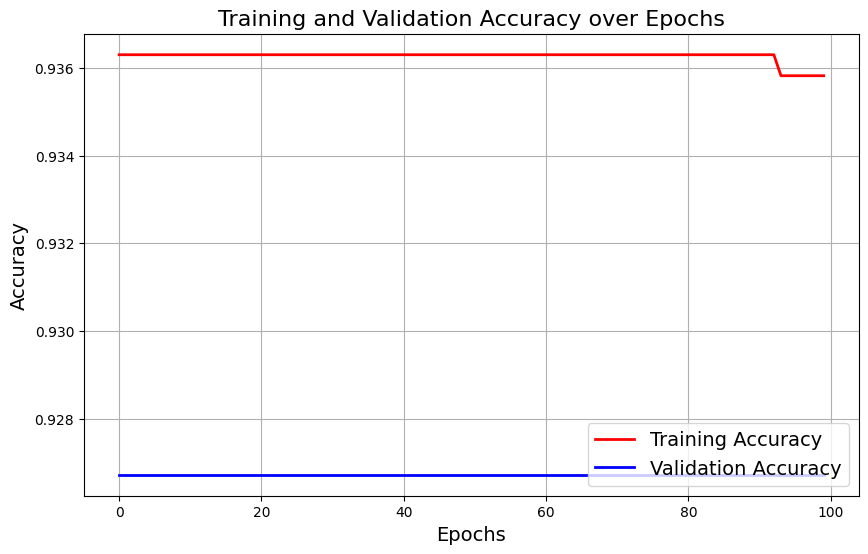

In [53]:
plt.figure(figsize=(10, 6))
plt.plot(train_accs, "r-", linewidth=2, label="Training Accuracy")
plt.plot(val_accs, "b-", linewidth=2, label="Validation Accuracy")
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.title("Training and Validation Accuracy over Epochs", fontsize=16)
plt.legend(loc="lower right", fontsize=14)
plt.grid(True)
plt.show()

# 5. Phân tích và Đánh giá Mô hình

In [54]:
y_test_encoded = y_test.map({"Introvert": 0, "Extrovert": 1})

X_test_prepared = full_pipeline.transform(X_test)

final_predictions = sgd_clf.predict(X_test_prepared)

accuracy = accuracy_score(y_test_encoded, final_predictions)
precision = precision_score(y_test_encoded, final_predictions)
recall = recall_score(y_test_encoded, final_predictions)
f1 = f1_score(y_test_encoded, final_predictions)

print(f"Accuracy  : {accuracy:.4f}")
print(f"Precision : {precision:.4f}")
print(f"Recall    : {recall:.4f}")
print(f"F1-Score  : {f1:.4f}")

Accuracy  : 0.9276
Precision : 0.9392
Recall    : 0.9205
F1-Score  : 0.9298


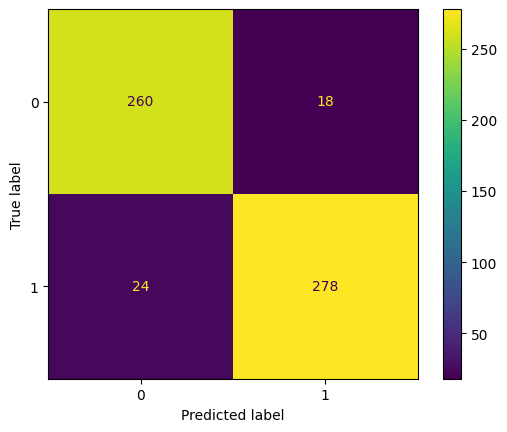

In [55]:
cfm = confusion_matrix(y_test_encoded, final_predictions)

disp = ConfusionMatrixDisplay(cfm)
disp.plot()

In [56]:
comparison_df = pd.DataFrame({
    'Dự đoán của Mô hình': final_predictions[:10],
    'Giá trị thực tế': y_test_encoded[:10].values
})

comparison_df["Đúng / Sai"] = comparison_df['Dự đoán của Mô hình'] == comparison_df['Giá trị thực tế']

print("So sánh 10 dự đoán đầu tiên trên tập test:")
comparison_df

So sánh 10 dự đoán đầu tiên trên tập test:


,Dự đoán của Mô hình,Giá trị thực tế,Đúng / Sai
0,0,0,True
1,1,1,True
2,0,0,True
3,0,0,True
4,0,0,True
5,0,0,True
6,0,0,True
7,1,1,True
8,0,0,True
9,0,0,True


In [57]:
import joblib

pipeline_filename = "pipeline.joblib"
model_filename = "model.joblib"

joblib.dump(full_pipeline, pipeline_filename)
print(f"Pipeline đã được lưu vào file: {pipeline_filename}")
joblib.dump(sgd_clf, model_filename)
print(f"Mô hình đã được lưu vào file: {model_filename}")

Pipeline đã được lưu vào file: pipeline.joblib
Mô hình đã được lưu vào file: model.joblib
